In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils.network as network_class
import utils.transformer_model as transformer_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer_transformer as data_processer_functions

import torch
import torch.nn as nn

import pickle
from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print('CUDA Version', torch.version.cuda)
print('PyTorch Version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 2080 Ti
CUDA Version 11.3
PyTorch Version 1.12.1


# Define Network 

In [3]:
num_nodes = 6
num_edges = 6

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1, 0, 0, 0, 0, 0], # -1 => node is edge's source
                                [ 1,-1, 0,-1, 0, 0], # 1 => node is edge's destination
                                [ 0, 1,-1, 0, 0, 0],
                                [ 0, 0, 0, 1,-1, 0],
                                [ 0, 0, 1, 0, 1,-1],
                                [ 0, 0, 0, 0, 0, 1]])

num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,1,0,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[0,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[0,:] = 2*np.array([0,1,1,0,0,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,0,1,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[1,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[1,:] = 2*np.array([0,0,0,1,1,1])

In [4]:
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel, 
    underlay_service_rates,
    external_arrival_rates)

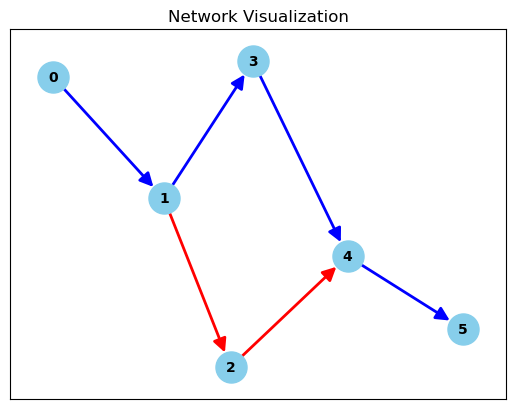

In [5]:
my_network.visualize(custom_seed = 8)

# Simulate Network

In [6]:
packets_in_flight_og, tunnel_backlogs_og, tunnel_injections_og, tunnel_exits_og = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)

In [7]:
T_start = 0
packets_in_flight, tunnel_backlogs, tunnel_injections, tunnel_exits = \
    packets_in_flight_og[T_start:,], tunnel_backlogs_og[T_start:,], tunnel_injections_og[T_start:,], tunnel_exits_og[T_start:,]

# Define Utility Functions

In [8]:
def prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers):
    # class to split data, scale data, and rescale data
    data_processer = data_processer_functions.DataProcessor()

    # create time series sequences with given look_back hyperparameter
    packets_in_flight_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back).to(device)
    tunnel_injections_all = data_processer.create_sequences(torch.Tensor(tunnel_injections), look_back).to(device)
    tunnel_exits_all = data_processer.create_sequences(torch.Tensor(tunnel_exits), look_back).to(device)

    # create transformer encoder inputs (source)
    src_all = data_processer.feature_transform(device, packets_in_flight_all)
    src_all = torch.concat((src_all, tunnel_injections_all), dim=-1)
    src_all = torch.concat((src_all, tunnel_exits_all), dim=-1)

    # create transformer decoder input/output (target)
    tgt_all = data_processer.create_sequences(torch.Tensor(tunnel_backlogs), look_back).to(device)

    # split into train and test
    src_train_unscaled, tgt_train_unscaled, \
        src_test_unscaled, tgt_test_unscaled = data_processer.split_train_test(src_all, tgt_all)

    # rescale to [0,1]
    src_train, tgt_train = data_processer.scale_train(src_train_unscaled, tgt_train_unscaled, is_x_sequenced = True)
    src_test, tgt_test = data_processer.scale_test(src_test_unscaled, tgt_test_unscaled)

    # decoder side of transformer will have inout and output
    tgt_train_input, tgt_train_output = data_processer.create_tgt_input_outputs(tgt_train, initial_fillers)
    tgt_test_input, tgt_test_output = data_processer.create_tgt_input_outputs(tgt_test, initial_fillers)

    return data_processer, src_train, tgt_train_input, tgt_train_output, src_test, tgt_test_input, tgt_test_output

In [9]:
def get_error_rates(transformer_predictor, src, tgt_output, data_processer, round_prediction = True):
    # get predictions
    transformer_predictor.eval()
    tgt_pred_output = transformer_predictor.evaluate(src)

    # rescale back to queue sizes
    _, tgt_pred_output_unscaled = data_processer.inverse_scale(src_scaled=0, tgt_scaled=tgt_pred_output)
    src_unscaled, tgt_output_unscaled = data_processer.inverse_scale(src_scaled=src, tgt_scaled=tgt_output)
    
    if(round_prediction): y_pred_unscaled = np.round(tgt_pred_output_unscaled.cpu().numpy())[:,-1,:]
    else: y_pred_unscaled = (tgt_pred_output_unscaled.cpu().numpy())[:,-1,:]
    y_unscaled = tgt_output_unscaled.cpu().numpy()[:,-1,:]

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y_unscaled, y_pred_unscaled, squared = False)
    mape = mean_absolute_percentage_error(y_unscaled[y_unscaled>0], y_pred_unscaled[y_unscaled>0])*100
    error_rates = {'rmse': rmse, 'mape': mape}

    return error_rates, src_unscaled.cpu().numpy(), y_unscaled, y_pred_unscaled

In [10]:
def plot_scatter_plot(x_in, y_in, title):
    plt.scatter(x_in[:, 1], x_in[:, 0], c = y_in, cmap='viridis', s=5, alpha=0.7)
    plt.xlabel('Packets in flight tunnel 1')
    plt.ylabel('Packets in flight tunnel 0')
    cbar = plt.colorbar()
    cbar.set_label(title)
    plt.show()
    
def plot_predicted_scatter(x_in, y, y_pred, tunnel_title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

    scatter1 = axs[0].scatter(x_in[:, 1], x_in[:, 0], c = y, cmap='viridis', s=5, alpha=0.7)
    axs[0].set_xlabel('Packets in flight tunnel 1')
    axs[0].set_ylabel('Packets in flight tunnel 0')
    colorbar1 = plt.colorbar(scatter1, ax=axs[0])
    colorbar1.set_label('True backlogs ' + tunnel_title)

    scatter2 = axs[1].scatter(x_in[:, 1], x_in[:, 0], c = y_pred, cmap='viridis', s=5, alpha=0.7)
    axs[1].set_xlabel('Packets in flight tunnel 1')
    axs[1].set_ylabel('Packets in flight tunnel 0')
    colorbar2 = plt.colorbar(scatter2, ax=axs[1])
    colorbar2.set_label('Predicted backlogs ' + tunnel_title)

    plt.tight_layout()
    plt.show()
    
def running_average(arr, window_size = 1000):
    arr = np.concatenate((np.zeros([window_size,]), arr), axis=0)
    cumsum = np.cumsum(arr)
    running_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return running_avg

def plot_queue_evolution(y, y_pred, tunnel_ii):
    T_to_plot = 5000
    window_size = 1
    plt.plot(running_average(y[:T_to_plot,tunnel_ii], window_size), label = 'True backlog')
    plt.plot(running_average(y_pred[:T_to_plot,tunnel_ii], window_size), label = 'Predicted backlog')
    plt.xlabel('Time')
    plt.ylabel('Tunnel backlogs of tunnel '+str(tunnel_ii))
    plt.legend()
    plt.show()

def plot_tunnel_scatter_plot(x, y, y_pred, tunnel_ii): 
    tt = -1 
    fig,ax=plt.subplots()
    ax.scatter(x[:,tt,tunnel_ii], y[:,tunnel_ii], label='True backlog', cmap='viridis', s=6, alpha=0.7)
    ax.scatter(x[:,tt,tunnel_ii], y_pred[:,tunnel_ii], label='Predicted backlog', cmap='viridis', s=6, alpha=0.5)
    ax.legend()
    ax.set_xlabel('Packets in flight tunnel '+str(tunnel_ii))
    ax.set_ylabel('Queue backlogs tunnel '+str(tunnel_ii))
    plt.show()

In [11]:
# used by transformer for masking future outputs
def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, device):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    return src_mask, tgt_mask

In [12]:
def train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers, \
                                    model_dim, num_heads, num_encoder_layers, num_decoder_layers, dropout, \
                                    learning_rate, num_epochs, batch_size, gamma_value):
    # prepare data
    data_processer, src_train, tgt_train_input, tgt_train_output, \
        src_test, _, tgt_test_output = prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers)

    # seeds for reproducibility
    np.random.seed(0)
    torch.manual_seed(0)
    src_size  = src_train.shape[-1]
    tgt_size = tgt_train_input.shape[-1]
    output_size = tgt_test_output.shape[-1]

    # define and initialize model
    transformer_predictor = transformer_model_class.TransformerModel(src_size, tgt_size, model_dim, output_size, look_back, \
                                                    num_heads, num_encoder_layers, num_decoder_layers, dropout, initial_fillers, device, generate_square_subsequent_mask).to(device)
    for p in transformer_predictor.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    # define tools for training with given hyperparameters
    trainer = model_trainer_class.modelTrainer(criterion = nn.SmoothL1Loss(beta=0.4), device = device)
    optimizer = torch.optim.Adam(transformer_predictor.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_value)

    # training loop
    pbar = trange(num_epochs)
    for epoch in pbar:
        trainer.random_perm_indices = np.random.permutation(np.arange(src_train.shape[0]))
        trainer.batch_start_index = 0
        tot_iters = np.int16(src_train.shape[0]/batch_size)+1
        for iter in range(tot_iters):
            # get batch and perform a training epoch 
            src_batch, tgt_batch_input, tgt_batch_output = trainer.get_train_batch_transformer(src_train, tgt_train_input, tgt_train_output, batch_size)
            src_mask, tgt_mask = create_mask(src_batch, tgt_batch_input, device)
            loss_value = trainer.batch_step_transformer(transformer_predictor, src_batch, tgt_batch_input, tgt_batch_output, src_mask, tgt_mask, optimizer) 
            pbar.set_postfix({'epoch': f'{epoch+1}/{num_epochs}', 'iter':f'{iter+1}/{tot_iters}', 'loss': loss_value, \
                              'look_back': src_train.shape[1], 'model_dim': model_dim, 'num_heads': num_heads, 'learning_rate': learning_rate})
        scheduler.step()

    # get performance metrics
    error_rates, _, _, _ = get_error_rates(transformer_predictor, src_test, tgt_test_output, data_processer)
    
    return transformer_predictor, error_rates

# Define and Train Model

In [ ]:
reload(data_processer_functions)
reload(transformer_model_class)
reload(model_trainer_class)

# create hyperparamer lists to explore
look_back_list = [15]
model_dim_num_heads_list = [[24,12]] # [[24,12], [20,10]]
learning_rate_list = [1e-3] #[1e-3,5e-3]
num_encoder_layers_list = [3]

initial_fillers = 1
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0
num_epochs = 25
batch_size = 128
gamma_value = 0.91

saved_models = []
for look_back in look_back_list:
    for model_dim_num_heads in model_dim_num_heads_list:
        for num_encoder_layers in num_encoder_layers_list:
            for learning_rate in learning_rate_list:
                # train and test the model
                num_decoder_layers = num_encoder_layers
                model, error_metrics = train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers, \
                                                                        model_dim_num_heads[0], model_dim_num_heads[1], num_encoder_layers, num_decoder_layers, dropout, \
                                                                        learning_rate, num_epochs, batch_size, gamma_value)

                # save trained model
                saved_models.append({
                            'model' : model,
                            'look_back': look_back,
                            'learning_rate': learning_rate,
                            'model_dim' : model_dim_num_heads[0],
                            'num_heads':model_dim_num_heads[1],
                            'error_metrics': error_metrics,
                            'num_decoder_layers':num_decoder_layers,
                            'initial_fillers':initial_fillers
                        })
            
# sort models according to best test rmse error
saved_models.sort(key = lambda x: (x['error_metrics']['rmse'], x['error_metrics']['mape'])) 

100%|██████████| 25/25 [09:15<00:00, 22.23s/it, epoch=25/25, iter=704/704, loss=0.000283, look_back=15, model_dim=24, num_heads=12, learning_rate=0.001]


In [ ]:
# print hyperparameter tuning summary
print('Best Transformer model parameters:')
pprint({k: saved_models[0][k] for k in saved_models[0].keys() - {'model'}})

print('\nPerfromance of all models:')
for ii in range(len(saved_models)):
    print(str(ii), saved_models[ii]['error_metrics'])

print(f'\n[{datetime.now().strftime("%d/%m/%Y %H:%M:%S")}]')

Best Transformer model parameters:
{'error_metrics': {'mape': 10.27197614312172, 'rmse': 7.642268},
 'learning_rate': 0.001,
 'look_back': 15,
 'model_dim': 24,
 'num_decoder_layers': 3,
 'num_heads': 12}

Perfromance of all models:
0 {'rmse': 7.642268, 'mape': 10.27197614312172}

[13/12/2023 22:35:03]


# Model Performance

In [13]:
file_name = 'final_network2'
# with open(file_name + '_saved_transformer_model.pkl', 'wb') as file: pickle.dump(saved_models[0], file)
# with open(file_name + '_saved_transformer_model.pkl', 'rb') as file: loaded_model = pickle.load(file)

In [14]:
# recreate best performing model
look_back = saved_models[0]['look_back']
transformer_predictor = saved_models[0]['model']
initial_fillers = saved_models[0]['initial_fillers']

# look_back = loaded_model['look_back']
# transformer_predictor = loaded_model['model']
# initial_fillers = loaded_model['initial_fillers']

# get its unrounded error performance 
data_processer, src_train, tgt_train_input, tgt_train_output, \
        src_test, _, tgt_test_output = prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers)
error_rates, x_test_final, y_test_final, y_pred_test_final = get_error_rates(transformer_predictor, src_test, tgt_test_output, data_processer, round_prediction=False)

# print its performance
print('Final unrounded performance of the best model:')
pprint(error_rates)

Final unrounded performance of the best model:
{'mape': 10.28178334236145, 'rmse': 7.637062}


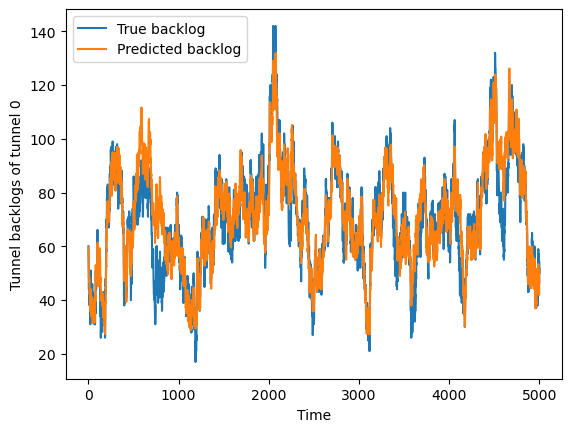

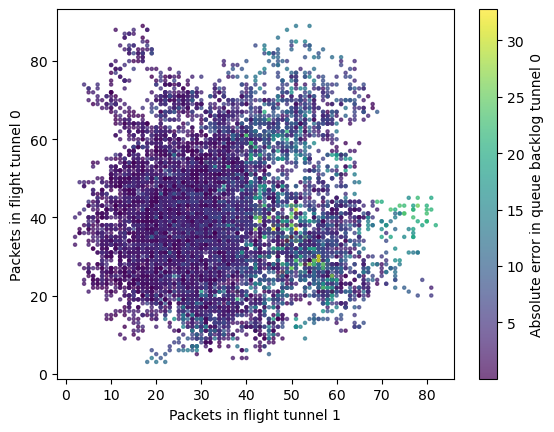

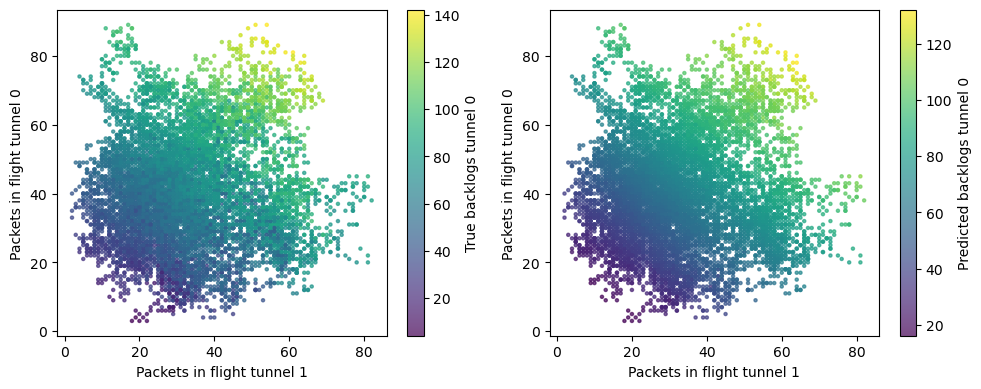

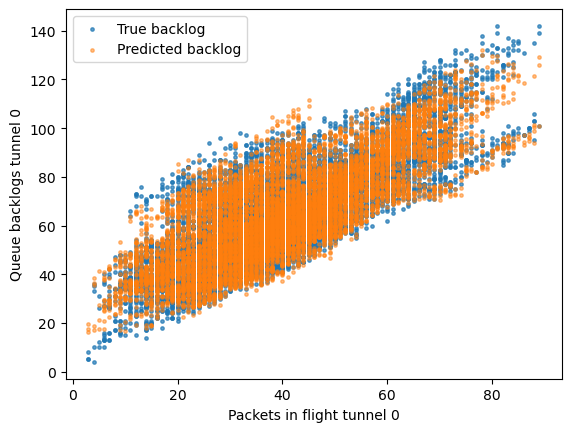

In [15]:
tt = -1
tunnel_ii = 0
plot_queue_evolution(y_test_final, y_pred_test_final, tunnel_ii)
plot_scatter_plot(x_test_final[:,tt,:], np.abs(y_test_final[:,tunnel_ii] - y_pred_test_final[:,tunnel_ii]), 'Absolute error in queue backlog tunnel '+str(tunnel_ii))
plot_predicted_scatter(x_test_final[:,tt,:], y_test_final[:,tunnel_ii], y_pred_test_final[:,tunnel_ii], tunnel_title = 'tunnel '+str(tunnel_ii))
plot_tunnel_scatter_plot(x_test_final, y_test_final, y_pred_test_final, tunnel_ii)

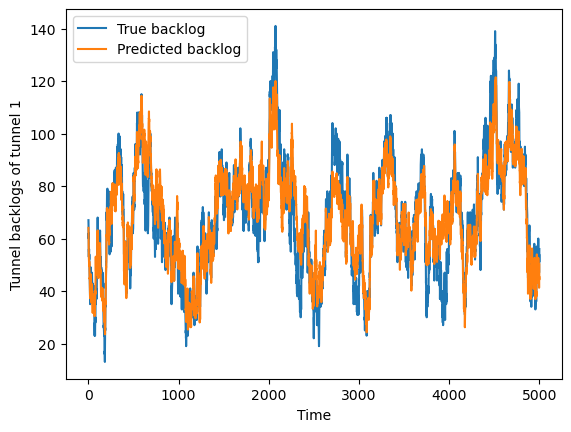

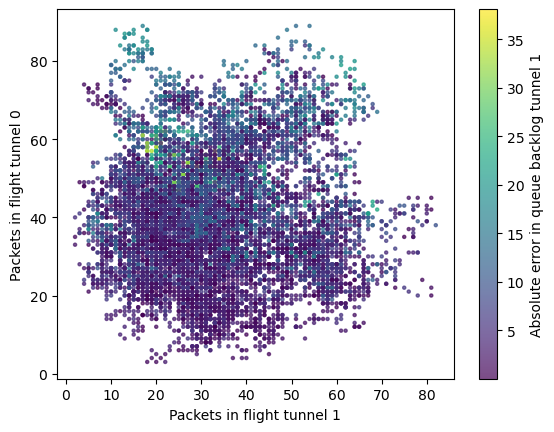

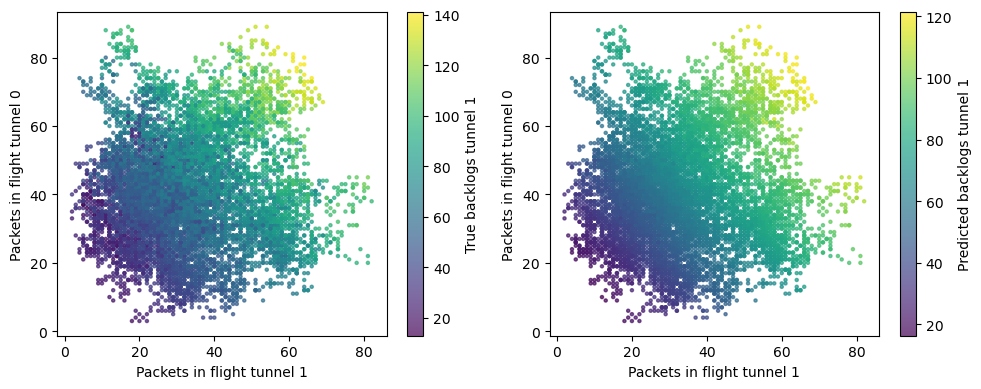

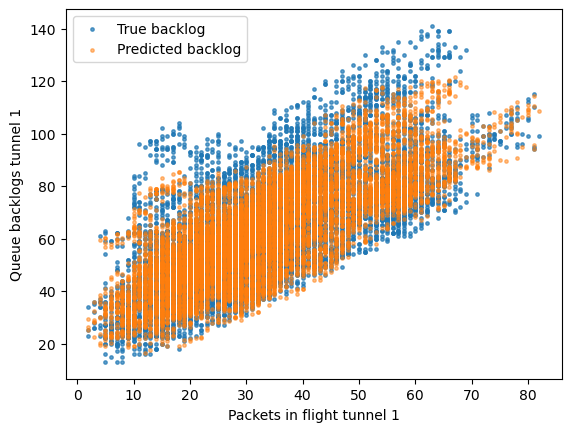

In [16]:
tt = -1
tunnel_ii = 1
plot_queue_evolution(y_test_final, y_pred_test_final, tunnel_ii)
plot_scatter_plot(x_test_final[:,tt,:], np.abs(y_test_final[:,tunnel_ii] - y_pred_test_final[:,tunnel_ii]), 'Absolute error in queue backlog tunnel '+str(tunnel_ii))
plot_predicted_scatter(x_test_final[:,tt,:], y_test_final[:,tunnel_ii], y_pred_test_final[:,tunnel_ii], tunnel_title = 'tunnel '+str(tunnel_ii))
plot_tunnel_scatter_plot(x_test_final, y_test_final, y_pred_test_final, tunnel_ii)